In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

2025-04-16 17:47:37.129735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744825657.307034      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744825657.360417      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Data Pre-Processing

## 1.1 Load Data

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


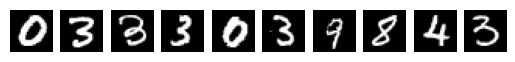

In [3]:
n = 10
fix, ax = plt.subplots(ncols=n)
samples = random.choices(train_x, k=n)
for i, sample in enumerate(samples):
    ax[i].imshow(sample, cmap='gray')
    ax[i].axis('off')
plt.show()

## 1.2 Normalize Images

In [4]:
# Scaling the data between -1 to 1
train_x = train_x/255
test_x = test_x/255

train_x = train_x[..., np.newaxis]
test_x = test_x[..., np.newaxis]

train_x.shape

(60000, 28, 28, 1)

In [5]:
train_x.max(), train_x.min()

(1.0, 0.0)

# 2. Define Sub Models and Models

In [6]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization
from tensorflow.keras.models import Sequential

## 2.1 Defining Generator Class

In [7]:
class Generator(tf.keras.Model):
    def __init__(self, latent_dim, n_layers, dropout, output_shape=(28,28,1)):
        super(Generator, self).__init__()
        layers = [Input(shape=(latent_dim,))]
        for i in range(n_layers-1):
            layers.append(Dense(128*2**(i), activation='relu'))
            layers.append(BatchNormalization())
            if dropout: layers.append(Dropout(rate=dropout))
        layers.append(Dense(np.prod(output_shape), activation='sigmoid'))
        layers.append(Reshape(target_shape=output_shape))
        self.model = Sequential(layers)
    def call(self, inputs):
        return self.model(inputs)

I0000 00:00:1744825673.136833      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28, 1)           │         571,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense (Dense)                   │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization             │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dropout (Dropout)               │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_1 (Dense)                 │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_1           │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dropout_1 (Dropout)             │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_2 (Dense)                 │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_2           │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dropout_2 (Dropout)             │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_3 (Dense)                 │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ reshape (Reshape)               │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 571,792 (2.18 MB)

 Trainable params: 570,000 (2.17 MB)

 Non-trainable params: 1,792 (7.00 KB)

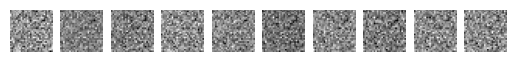

In [8]:
gen = Generator(latent_dim = 10, n_layers=4, dropout = 0.3, output_shape=(28,28,1))
gen.summary(expand_nested=True)
y = gen(tf.random.normal(shape=(256,10)))
n = 10
fix, ax = plt.subplots(ncols=n)
samples = random.choices(y, k=n)
for i, sample in enumerate(samples):
    ax[i].imshow(sample, cmap='gray')
    ax[i].axis('off')
plt.show()

## 2.2 Defining Discriminator Class

In [9]:
class Discriminator(tf.keras.Model):
    def __init__(self, input_shape, n_layers, dropout):
        super(Discriminator, self).__init__()
        layers = [Input(shape=input_shape), Flatten()]
        for i in range(n_layers):
            layers.append(Dense(512//2**i, activation='relu'))
            layers.append(BatchNormalization())
            if dropout: layers.append(Dropout(rate=dropout))
        layers.append(Dense(1, activation='sigmoid')) # using linear
        self.model = Sequential(layers)
    def call(self, inputs):
        return self.model(inputs)

In [10]:
discriminator = Discriminator(input_shape=(28,28,1), n_layers = 4, dropout = 0.3)
discriminator.summary(expand_nested=True)
cls = discriminator(y)
cls.shape

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 1)                   │         578,305 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ flatten (Flatten)               │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_4 (Dense)                 │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_3           │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dropout_3 (Dropout)             │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_5 (Dense)                 │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_4           │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dropout_4 (Dropout)             │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_6 (Dense)                 │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_5           │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dropout_5 (Dropout)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_7 (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ batch_normalization_6           │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dropout_6 (Dropout)             │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ dense_8 (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 578,305 (2.21 MB)

 Trainable params: 576,385 (2.20 MB)

 Non-trainable params: 1,920 (7.50 KB)

TensorShape([256, 1])

## 2.3 Defining Loss and Metric Function

In [11]:
def dis_loss(base_loss, real_critic_output, fake_critic_output):
    batch_size = tf.shape(real_critic_output)[0]

    ones = tf.ones((batch_size, 1)) * tf.random.uniform((batch_size, 1), 0.95, 1) # smooth real labels
    zeros = tf.zeros((batch_size, 1)) + tf.random.uniform((batch_size, 1), 0, 0.05)  # noisy 0s

    y_pred = tf.concat([real_critic_output, fake_critic_output], axis=0)
    y_act = tf.concat([ones, zeros], axis=0)
    loss = base_loss(y_act, y_pred)
        
    return loss

# def gen_loss(base_loss, fake_critic_output):
#     batch_size = tf.shape(fake_critic_output)[0]
#     zeros = tf.zeros((batch_size, 1)) + tf.random.uniform((batch_size, 1), 0, 0.1)  # noisy 0s
#     fake_loss = base_loss(zeros, fake_critic_output)

#     return fake_loss

def gen_loss(base_loss, fake_critic_output):
    batch_size = tf.shape(fake_critic_output)[0]

    # The generator wants the fake images to be classified as real
    target_labels = tf.ones((batch_size, 1)) * tf.random.uniform((batch_size, 1), 0.95, 1)  # smoothed real labels

    loss = base_loss(target_labels, fake_critic_output)
    
    return loss

def dis_accuracy(real_critic_output, fake_critic_output):
    # real_critic_output and fake_critic_output are LOGITS

    # Convert logits to probabilities (0 to 1)
    # real_prob = tf.sigmoid(real_critic_output)
    # fake_prob = tf.sigmoid(fake_critic_output)

    # Convert probabilities to predictions (0 or 1) by thresholding at 0.5
    real_preds = tf.cast(real_critic_output >= 0.5, tf.float32)
    fake_preds = tf.cast(fake_critic_output >= 0.5, tf.float32)

    # Create target labels
    ones = tf.ones_like(real_preds)  # Target for real images is 1
    zeros = tf.zeros_like(fake_preds) # Target for fake images is 0

    # Calculate accuracy for real images (preds should be 1)
    real_acc = tf.reduce_mean(tf.cast(tf.equal(real_preds, ones), tf.float32))
    # Calculate accuracy for fake images (preds should be 0)
    fake_acc = tf.reduce_mean(tf.cast(tf.equal(fake_preds, zeros), tf.float32))

    # Return the average accuracy
    return (real_acc + fake_acc) / 2

## 2.4 Defining GAN Class

In [12]:
class GAN(tf.keras.Model):
    def __init__(self, generator : Generator, discriminator : Discriminator, latent_dim : int):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
    
    def compile(self, gen_optimizer, disc_optimizer, base_loss, gen_loss, disc_loss):
        super(GAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss = base_loss
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        
    # Faking the call to build the model
    def call(self, inputs, training=False):
        # Just build the model, even if not directly used
        return self.discriminator(inputs, training=training)
        
    @tf.function
    def train_step(self, images):
        batch_size = tf.shape(images)[0]

        # generating random noise
        for _ in range(1):
            z = tf.random.normal(shape=(batch_size,self.latent_dim))

            # Training Discriminator by making Generator fixed
            with tf.GradientTape() as tape:
                generated_images = self.generator(z, training=False) # freezing the generator
                real_critic_output = self.discriminator(images, training=True)
                fake_critic_output = self.discriminator(generated_images, training=True)
                disc_loss = self.disc_loss(self.loss, real_critic_output, fake_critic_output)
                
            disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_weights)
            self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))
            acc = dis_accuracy(real_critic_output, fake_critic_output)
        
        for _ in range(32): # Training Generator twice for better chance in MiniMax algo of winning
            # Training the Generator by making Discriminator fixed
            z = tf.random.normal(shape=(batch_size,self.latent_dim))
            with tf.GradientTape() as tape:
                generated_images = self.generator(z, training=True) 
                fake_critic_output = self.discriminator(generated_images, training=False) # freezing the discriminator
                gen_loss = self.gen_loss(self.loss, fake_critic_output)

            gen_grads = tape.gradient(gen_loss, self.generator.trainable_weights)
            self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_weights))
        
        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss, 'Accuracy' : acc}
    
    # @tf.function
    # def train_step(self, images):
    #     batch_size = tf.shape(images)[0]
    #     # generating random noise
    #     z = tf.random.normal(shape=(batch_size,self.latent_dim))

    #     with tf.GradientTape(persistent=True) as tape:
    #         generated_images = self.generator(z, training=True)

    #         real_critic_output = self.discriminator(images, training=True)
    #         fake_critic_output = self.discriminator(generated_images, training=True)

    #         disc_loss = self.disc_loss(self.loss, real_critic_output, fake_critic_output)        
    #         gen_loss = self.gen_loss(self.loss, fake_critic_output)

    #     disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
    #     self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
    #     acc = dis_accuracy(real_critic_output, fake_critic_output)
        
    #     gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
    #     self.gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        
        # return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss, 'Accuracy' : acc}

## 2.5. Define Image Saving Callback

In [13]:
class SavePlots(tf.keras.callbacks.Callback):
    def __init__(self, nrows = 4, ncols = 4, latent_dim = 100, saving_rate=100):
        if not os.path.exists('/kaggle/working/images'):
            os.mkdir('/kaggle/working/images')
        self.z = tf.random.normal(shape=(nrows*ncols, latent_dim))
        self.saving_rate = saving_rate
    def save_image(self, epoch):
        # Number of images = 16
        gen_imgs = self.model.generator(self.z)
        gen_imgs =( gen_imgs.numpy()*255).astype('int') # convert back to [0,255]
        fig = plt.figure(figsize=(4, 4))

        for i in range(gen_imgs.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        fig.savefig(f"images/mnist_{epoch}.png")
        plt.close()
    def on_epoch_end(self, epoch, logs=None):
        if epoch%self.saving_rate==0:
            self.save_image(epoch)

# 3. Model Instances and Setup

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

In [15]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

## 3.1 Hyper Parameter Definition

In [16]:
# Hyper Params
latent_dim = 32
n_layers = 4
dropout = 0.0
output_shape = (28,28,1)
learning_rate_generator = 2e-4
learning_rate_discriminator = 1e-4
epochs = 4000

## 3.2 Model Instance Under GPU Scope

In [17]:
with strategy.scope(): 
    # define models
    generator = Generator(latent_dim = latent_dim, 
                          n_layers = n_layers, 
                          dropout = dropout, 
                          output_shape=output_shape)
    discriminator = Discriminator(input_shape=output_shape, n_layers=n_layers, dropout = dropout)
    gan = GAN(generator = generator, discriminator = discriminator, latent_dim = latent_dim)

    # define optimizers
    gen_opt = Adam(learning_rate = learning_rate_generator, beta_1=0.5, beta_2=0.999,)
    disc_opt = Adam(learning_rate = learning_rate_discriminator, beta_1=0.5, beta_2=0.999,)

    # define losses
    base_loss = BinaryCrossentropy(from_logits=False) # as not applied sigmoid thus from_logit=True is kept as default

    gan.compile(gen_optimizer = gen_opt, 
                disc_optimizer = disc_opt, 
                base_loss = base_loss, 
                gen_loss = gen_loss, 
                disc_loss = dis_loss)

In [18]:
gan.summary(expand_nested=True)

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ generator_1 (Generator)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ sequential_2 (Sequential)       │ (None, 28, 28, 1)           │         574,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ dense_9 (Dense)              │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ batch_normalization_7        │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ dense_10 (Dense)             │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ batch_normalization_8        │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ dense_11 (Dense)             │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ batch_normalization_9        │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ dense_12 (Dense)             │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ reshape_1 (Reshape)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ discriminator_1 (Discriminator)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ sequential_3 (Sequential)       │ (None, 1)                   │         578,305 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ flatten_1 (Flatten)          │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ dense_13 (Dense)             │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ batch_normalization_10       │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ dense_14 (Dense)             │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ batch_normalization_11       │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ dense_15 (Dense)             │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ batch_normalization_12       │ (None, 128)                 │             5

 Total params: 1,152,913 (4.40 MB)

 Trainable params: 1,149,201 (4.38 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [19]:
callbacks = [
    SavePlots(saving_rate=10, latent_dim=latent_dim),
    ModelCheckpoint(filepath = 'GAN.keras', monitor='Generator Loss', save_best_only=True, mode='min')
]

# 4. Training GAN

In [20]:
gan.fit(train_x, epochs=epochs, callbacks=callbacks, batch_size=1024, verbose=2)

Epoch 1/4000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'gan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


59/59 - 100s - 2s/step - Accuracy: 0.5000 - Discriminator Loss: 1.0487 - Generator Loss: 0.1972
Epoch 2/4000
59/59 - 8s - 129ms/step - Accuracy: 0.0387 - Discriminator Loss: 0.8752 - Generator Loss: 0.4801
Epoch 3/4000
59/59 - 8s - 131ms/step - Accuracy: 8.2237e-04 - Discriminator Loss: 0.7752 - Generator Loss: 0.6199
Epoch 4/4000
59/59 - 8s - 128ms/step - Accuracy: 0.0000e+00 - Discriminator Loss: 0.7774 - Generator Loss: 0.6349
Epoch 5/4000
59/59 - 8s - 129ms/step - Accuracy: 0.0000e+00 - Discriminator Loss: 0.7732 - Generator Loss: 0.6006
Epoch 6/4000
59/59 - 8s - 129ms/step - Accuracy: 0.0000e+00 - Discriminator Loss: 0.7448 - Generator Loss: 0.6931
Epoch 7/4000
59/59 - 8s - 132ms/step - Accuracy: 0.5000 - Discriminator Loss: 0.7251 - Generator Loss: 0.7154
Epoch 8/4000
59/59 - 8s - 130ms/step - Accuracy: 0.5000 - Discriminator Loss: 0.6972 - Generator Loss: 0.7289
Epoch 9/4000
59/59 - 8s - 129ms/step - Accuracy: 0.5000 - Discriminator Loss: 0.7136 - Generator Loss: 0.7089
Epoch 10